# 01 Token Analysis

Analyze the TinyStories dataset to find the minimum viable vocabulary size.

**Goal:** Determine how many tokens we actually need to cover TinyStories with minimal OOV, so we can choose the smallest vocab that works (smaller W = easier recording).

In [1]:
# === Parameters ===
DATASET_NAME = "roneneldan/TinyStories"
SPLIT = "train"
RANDOM_SEED = 42

# How many stories to sample for analysis (None = all)
# Full dataset is ~2.1M stories; we'll sample for speed
SAMPLE_SIZE = 100_000

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import GPT2TokenizerFast
from tqdm.auto import tqdm

print("Imports complete.")

Imports complete.


## Load Dataset and Tokenizer

In [3]:
# Load GPT-2 tokenizer (full 50,257 vocab)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
print(f"GPT-2 tokenizer loaded. Vocab size: {tokenizer.vocab_size:,}")

# Load TinyStories dataset (streams from HF, caches locally)
print(f"\nLoading {DATASET_NAME}...")
dataset = load_dataset(DATASET_NAME, split=SPLIT)
print(f"Dataset loaded. Total stories: {len(dataset):,}")

GPT-2 tokenizer loaded. Vocab size: 50,257

Loading roneneldan/TinyStories...
Dataset loaded. Total stories: 2,119,719


In [4]:
# Sample if requested
if SAMPLE_SIZE and SAMPLE_SIZE < len(dataset):
    dataset = dataset.shuffle(seed=RANDOM_SEED).select(range(SAMPLE_SIZE))
    print(f"Sampled {SAMPLE_SIZE:,} stories for analysis.")
else:
    print(f"Using full dataset: {len(dataset):,} stories.")

Sampled 100,000 stories for analysis.


## Tokenize and Count

In [5]:
# Batched tokenization - much faster than one-at-a-time
# The HuggingFace tokenizer is optimized for batch processing

BATCH_SIZE = 1000  # Process 1000 stories at a time

token_counts = Counter()
total_tokens = 0

# Process in batches
texts = dataset["text"]  # Extract all texts
n_batches = (len(texts) + BATCH_SIZE - 1) // BATCH_SIZE

for i in tqdm(range(n_batches), desc="Tokenizing batches"):
    start = i * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(texts))
    batch_texts = texts[start:end]

    # Batch encode - returns list of lists
    batch_encodings = tokenizer(batch_texts, add_special_tokens=False)["input_ids"]

    for tokens in batch_encodings:
        token_counts.update(tokens)
        total_tokens += len(tokens)

print(f"\nTotal tokens: {total_tokens:,}")
print(f"Unique tokens: {len(token_counts):,}")
print(f"Tokens per story (avg): {total_tokens / len(dataset):.1f}")

Tokenizing batches:   0%|          | 0/100 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1087 > 1024). Running this sequence through the model will result in indexing errors



Total tokens: 22,205,468
Unique tokens: 17,852
Tokens per story (avg): 222.1


## Analyze Token Distribution

In [6]:
# Sort tokens by frequency
sorted_tokens = token_counts.most_common()

# Top 20 tokens
print("Top 20 tokens:")
print("-" * 40)
for token_id, count in sorted_tokens[:20]:
    token_str = tokenizer.decode([token_id])
    pct = 100 * count / total_tokens
    print(f"  {token_id:5d}  {repr(token_str):15s}  {count:10,d}  ({pct:.2f}%)")

Top 20 tokens:
----------------------------------------
     13  '.'               1,628,331  (7.33%)
    198  '\n'                866,219  (3.90%)
    290  ' and'              835,653  (3.76%)
    262  ' the'              783,538  (3.53%)
     11  ','                 783,410  (3.53%)
    284  ' to'               594,930  (2.68%)
    257  ' a'                534,542  (2.41%)
    373  ' was'              445,413  (2.01%)
    340  ' it'               245,156  (1.10%)
    607  ' her'              212,248  (0.96%)
   1375  ' She'              210,038  (0.95%)
    679  ' He'               201,517  (0.91%)
   1119  ' They'             181,718  (0.82%)
    531  ' said'             168,714  (0.76%)
    339  ' he'               163,871  (0.74%)
    366  ' "'                163,561  (0.74%)
    287  ' in'               148,807  (0.67%)
    673  ' she'              146,175  (0.66%)
    351  ' with'             143,681  (0.65%)
    465  ' his'              135,107  (0.61%)


In [7]:
# Calculate cumulative coverage
counts = np.array([count for _, count in sorted_tokens])
cumulative = np.cumsum(counts) / total_tokens

# Find vocab sizes for various coverage levels
coverage_targets = [0.90, 0.95, 0.99, 0.995, 0.999, 1.0]

print("\nVocab size needed for coverage:")
print("-" * 40)
for target in coverage_targets:
    idx = np.searchsorted(cumulative, target)
    vocab_needed = min(idx + 1, len(cumulative))
    actual_coverage = cumulative[min(idx, len(cumulative)-1)]
    print(f"  {target*100:5.1f}% coverage: {vocab_needed:,} tokens")


Vocab size needed for coverage:
----------------------------------------
   90.0% coverage: 951 tokens
   95.0% coverage: 1,904 tokens
   99.0% coverage: 4,480 tokens
   99.5% coverage: 5,911 tokens
   99.9% coverage: 10,100 tokens
  100.0% coverage: 17,852 tokens


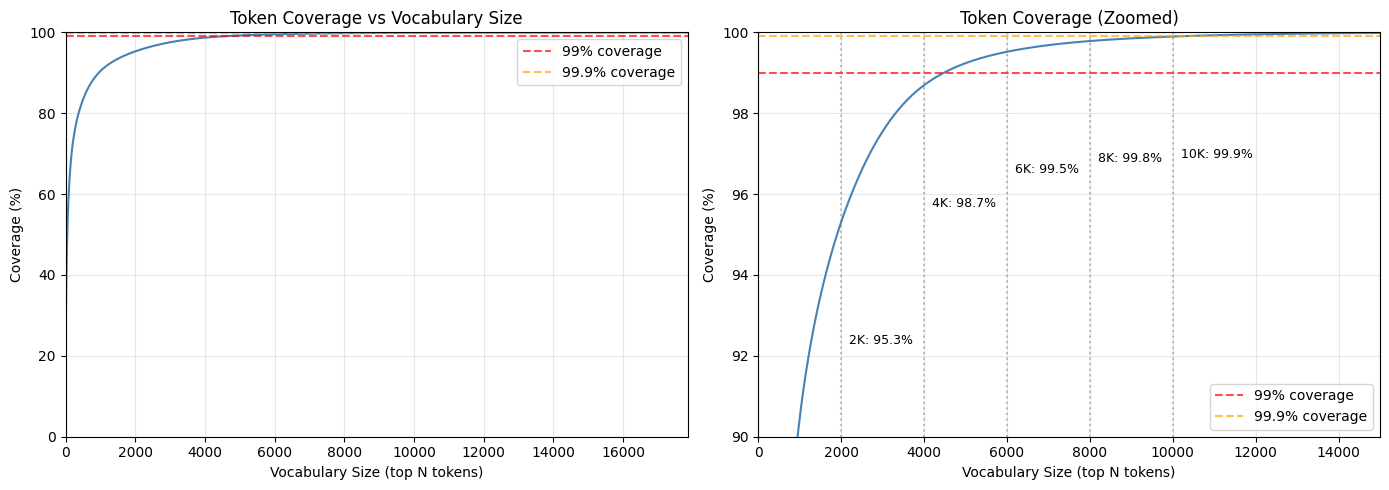

Saved: token_coverage.png


In [8]:
# Plot cumulative coverage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Full view
ax1.plot(range(1, len(cumulative)+1), cumulative * 100, color='steelblue', linewidth=1.5)
ax1.axhline(y=99, color='red', linestyle='--', alpha=0.7, label='99% coverage')
ax1.axhline(y=99.9, color='orange', linestyle='--', alpha=0.7, label='99.9% coverage')
ax1.set_xlabel('Vocabulary Size (top N tokens)')
ax1.set_ylabel('Coverage (%)')
ax1.set_title('Token Coverage vs Vocabulary Size')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, len(cumulative))
ax1.set_ylim(0, 100)

# Right plot: Zoomed to first 15K tokens
zoom_n = min(15000, len(cumulative))
ax2.plot(range(1, zoom_n+1), cumulative[:zoom_n] * 100, color='steelblue', linewidth=1.5)
ax2.axhline(y=99, color='red', linestyle='--', alpha=0.7, label='99% coverage')
ax2.axhline(y=99.9, color='orange', linestyle='--', alpha=0.7, label='99.9% coverage')

# Mark some key points
for vocab_size in [2000, 4000, 6000, 8000, 10000]:
    if vocab_size <= len(cumulative):
        cov = cumulative[vocab_size-1] * 100
        ax2.axvline(x=vocab_size, color='gray', linestyle=':', alpha=0.5)
        ax2.annotate(f'{vocab_size//1000}K: {cov:.1f}%', 
                    xy=(vocab_size, cov), 
                    xytext=(vocab_size+200, cov-3),
                    fontsize=9)

ax2.set_xlabel('Vocabulary Size (top N tokens)')
ax2.set_ylabel('Coverage (%)')
ax2.set_title('Token Coverage (Zoomed)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, zoom_n)
ax2.set_ylim(90, 100)

plt.tight_layout()
plt.savefig('token_coverage.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: token_coverage.png")

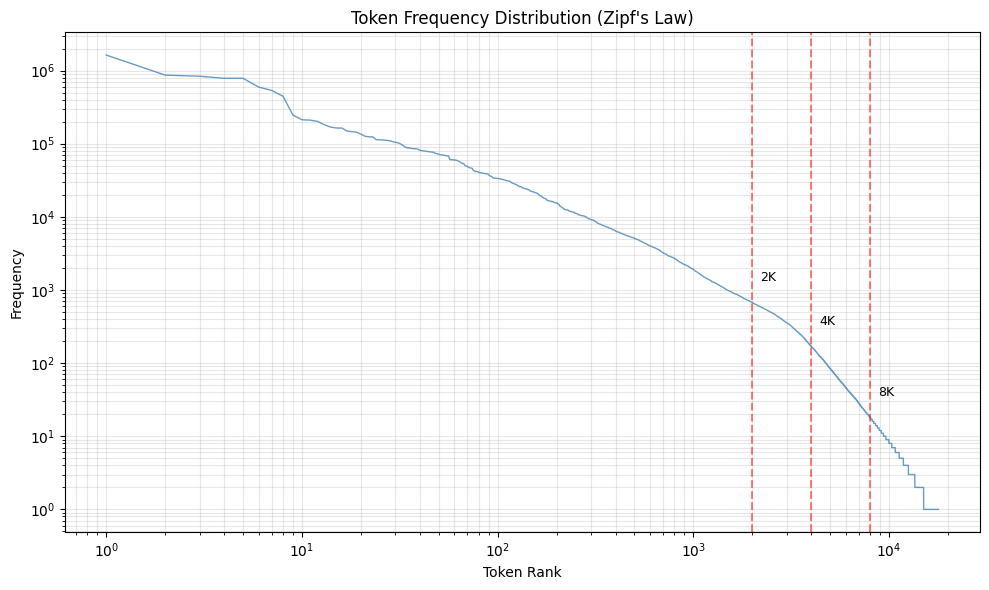

Saved: token_frequency.png


In [9]:
# Plot token frequency distribution (log scale)
fig, ax = plt.subplots(figsize=(10, 6))

ax.loglog(range(1, len(counts)+1), counts, color='steelblue', linewidth=1, alpha=0.8)
ax.set_xlabel('Token Rank')
ax.set_ylabel('Frequency')
ax.set_title('Token Frequency Distribution (Zipf\'s Law)')
ax.grid(True, alpha=0.3, which='both')

# Mark key vocab sizes
for vocab_size in [2000, 4000, 8000]:
    if vocab_size <= len(counts):
        ax.axvline(x=vocab_size, color='red', linestyle='--', alpha=0.5)
        ax.annotate(f'{vocab_size//1000}K', xy=(vocab_size, counts[vocab_size-1]),
                   xytext=(vocab_size*1.1, counts[vocab_size-1]*2), fontsize=9)

plt.tight_layout()
plt.savefig('token_frequency.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: token_frequency.png")

## Recommendation

In [10]:
# Find minimum vocab for 99.5% coverage (good balance)
target_coverage = 0.995
idx = np.searchsorted(cumulative, target_coverage)
min_vocab = idx + 1

print("=" * 50)
print("RECOMMENDATION")
print("=" * 50)
print(f"\nFor {target_coverage*100:.1f}% coverage: {min_vocab:,} live tokens")
print(f"\nSuggested configurations:")
print(f"  Conservative: {min_vocab:,} live + 1,000 dead = {min_vocab + 1000:,} total")
print(f"  Aggressive:   {min_vocab:,} live + 2,000 dead = {min_vocab + 2000:,} total")
print(f"\nFor comparison:")
print(f"  TinyStoriesTinker used ~10,000 total vocab")
print(f"  TinyStories paper used 10,000 total vocab")
print(f"\nUnique tokens in sample: {len(token_counts):,}")
print(f"GPT-2 full vocab: {tokenizer.vocab_size:,}")

RECOMMENDATION

For 99.5% coverage: 5,911 live tokens

Suggested configurations:
  Conservative: 5,911 live + 1,000 dead = 6,911 total
  Aggressive:   5,911 live + 2,000 dead = 7,911 total

For comparison:
  TinyStoriesTinker used ~10,000 total vocab
  TinyStories paper used 10,000 total vocab

Unique tokens in sample: 17,852
GPT-2 full vocab: 50,257


In [11]:
# Check what tokens would be OOV at various vocab sizes
print("\nOOV analysis at various vocab sizes:")
print("-" * 50)

top_token_ids = set(token_id for token_id, _ in sorted_tokens)

for vocab_size in [2000, 4000, 6000, 8000, 10000]:
    top_n = set(token_id for token_id, _ in sorted_tokens[:vocab_size])
    oov_tokens = top_token_ids - top_n
    oov_count = sum(token_counts[t] for t in oov_tokens)
    oov_pct = 100 * oov_count / total_tokens
    print(f"  Vocab {vocab_size:,}: {len(oov_tokens):,} OOV types, {oov_count:,} OOV tokens ({oov_pct:.3f}%)")


OOV analysis at various vocab sizes:
--------------------------------------------------
  Vocab 2,000: 15,852 OOV types, 1,042,935 OOV tokens (4.697%)
  Vocab 4,000: 13,852 OOV types, 290,552 OOV tokens (1.308%)
  Vocab 6,000: 11,852 OOV types, 106,754 OOV tokens (0.481%)
  Vocab 8,000: 9,852 OOV types, 47,744 OOV tokens (0.215%)
  Vocab 10,000: 7,852 OOV types, 23,003 OOV tokens (0.104%)


## Summary

This notebook analyzed the TinyStories dataset to determine minimum viable vocabulary size.

**Key findings:**
- Total unique tokens used in dataset
- Coverage curve showing diminishing returns past ~4-6K tokens
- Recommended vocab size for Duckling_II

**Next step:** Create truncated tokenizer with dead token padding (notebook 02).